In [29]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import copy
%matplotlib inline

In [30]:
manualSeed = random.randint(1, 10000)  # fix seed
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  4642


In [31]:
coco_dataset = dset.CocoCaptions(
    root='inpainting/train2014',
    annFile='inpainting/annotations/captions_train2014.json',
    transform=transforms.ToTensor()
)

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!


In [42]:
class DataIterator(object):
    """Data Iterator for COCO."""

    def __init__(
        self,
        train_path='inpainting/train2014',
        dev_path='inpainting/val2014',
        train_annotation_path='inpainting/annotations/captions_train2014.json',
        dev_annotation_path='inpainting/annotations/captions_val2014.json',
    ):
        """Initialize params."""
        self.train_path = train_path
        self.train_annotation_path = train_annotation_path
        self.dev_path = dev_path
        self.dev_annotation_path = dev_annotation_path
        print('Processing data ...')
        self._get_real_and_fake_images()

    # JMAK - cropping to 128
    def _get_real_and_fake_images(self):
        """Get real and fake images from path."""
        self.train_dataset = dset.CocoCaptions(
            root=self.train_path,
            annFile=self.train_annotation_path,
            transform=transforms.Compose([
                 transforms.CenterCrop(128),
                 transforms.ToTensor()])
        )
       
        
        self.valid_dataset = dset.CocoCaptions(
            root=self.dev_path, 
            annFile=self.dev_annotation_path,
            transform=transforms.Compose([
                 transforms.CenterCrop(128),
                 transforms.ToTensor()])
        )
        
        # ELDRICK: First, copy over desired number of training and validation. 
        print('Populating training images & captions ...')
        train_images = []
        train_captions = []
        # There appears to be one image missing for some weird reason.
        i = 0
        try:
            for img, captions in self.train_dataset:
                train_images.append(img)
                train_captions.append(captions)
                i += 1
                if i == 1e3:
                    break
        except IOError:
            pass
        
        train_images = torch.stack(train_images)
        
        # ELDRICK: Second, changed this to match above to terminate
        print('Populating validation images ...')
        valid_images = []
        valid_captions = []
        i = 0
        try:
            for img, captions in self.valid_dataset:
                valid_images.append(img)
                valid_captions.append(captions)
                i += 1
                if i == 1e3:
                    break
        except IOError:
            pass
        
        valid_images = torch.stack(valid_images)
#         valid_images = torch.stack([x[0] for x in self.valid_dataset])
#         valid_captions = [x[1] for x in self.valid_dataset]
        
        # ELDRICK: Crop out 128 by 128
        # JMAK: Crop out 64x64 
        print('Cropping 64x64 patch for training images ...')
        noisy_train_images = copy.deepcopy(train_images.numpy())
        noisy_train_images[:, :, 32:96, 32:96] = 0
        noisy_train_images = torch.from_numpy(noisy_train_images)

        print('Cropping 64x64 patch for validation images ...')
        noisy_valid_images = copy.deepcopy(valid_images.numpy())
        noisy_valid_images[:, :, 32:96, 32:96] = 0
        noisy_valid_images = torch.from_numpy(noisy_valid_images)
        
        self.train_images = train_images
        self.valid_images = valid_images

        self.noisy_train_images = noisy_train_images
        self.noisy_valid_images = noisy_valid_images
        
        self.num_train = len(train_images)
        self.num_valid = len(valid_images)

    # Return proper sized samples from minibatch - 128x128
    # return a 64 x 64 minibatch - JMAK
    def get_train_minibatch(self, index, batch_size):
        """Return a minibatch of real and fake examples."""
        real_examples = Variable(self.train_images[index: index + batch_size]).cuda()
        fake_examples = Variable(self.noisy_train_images[index: index + batch_size]).cuda()
        return real_examples, real_examples[:, :, 32:96, 32:96], fake_examples

    def get_valid_minibatch(self, index, batch_size):
        """Return a minibatch of real and fake examples."""
        real_examples = Variable(self.valid_images[index: index + batch_size]).cuda()
        fake_examples = Variable(self.noisy_valid_images[index: index + batch_size]).cuda()
        
        return real_examples, real_examples[:, :, 32:96, 32:96], fake_examples

In [43]:
iterator = DataIterator()

Processing data ...
loading annotations into memory...
Done (t=0.69s)
creating index...
index created!
loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
Populating training images & captions ...
Populating validation images ...
Cropping 64x64 patch for training images ...
Cropping 64x64 patch for validation images ...


(-0.5, 127.5, 127.5, -0.5)

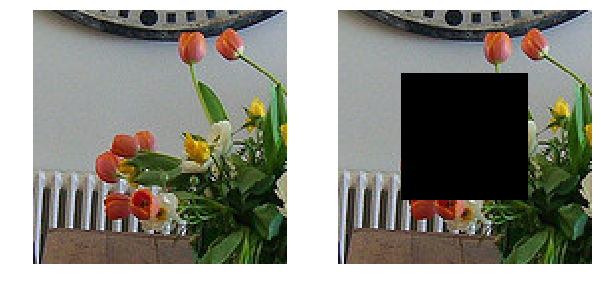

In [44]:
fig = plt.figure(figsize=(10, 5))
fig.add_subplot(1, 2, 1)
plt.imshow(iterator.train_images[6].numpy().transpose(1, 2, 0))
plt.axis('off')
fig.add_subplot(1, 2, 2)
plt.imshow(iterator.noisy_train_images[6].numpy().transpose(1, 2, 0))
plt.axis('off')

In [45]:
class UNetGeneratorSkip(nn.Module):
    """Generator module."""

    def __init__(self, start_filter):
        """Initialize generator."""
        super(UNetGeneratorSkip, self).__init__()

        #################################
        ####### DOWNSAMPLER MODULE ######
        #################################

#         # 3 x 64 x 64
#         self.conv1 = nn.Conv2d(
#             in_channels=3, out_channels=start_filter, kernel_size=4,
#             stride=2, padding=1, bias=False
#         )
#         self.bn1 = nn.BatchNorm2d(start_filter)

#         # 16 x 32 x 32
#         self.conv2 = nn.Conv2d(
#             in_channels=start_filter, out_channels=start_filter * 2,
#             kernel_size=4, stride=2, padding=1, bias=False
#         )
#         self.bn2 = nn.BatchNorm2d(start_filter * 2)

#         # 32 x 16 x 16
#         self.conv3 = nn.Conv2d(
#             in_channels=start_filter * 2, out_channels=start_filter * 4,
#             kernel_size=4, stride=2, padding=1, bias=False
#         )
#         self.bn3 = nn.BatchNorm2d(start_filter * 4)

#         # 48 x 8 x 8
#         self.conv4 = nn.Conv2d(
#             in_channels=start_filter * 4, out_channels=start_filter * 8,
#             kernel_size=4, stride=2, padding=1, bias=False
#         )
#         self.bn4 = nn.BatchNorm2d(start_filter * 8)

#         #################################
#         ####### UPSAMPLER MODULE ########
#         #################################

#         # 64 x 4 x 4
#         self.tconv1 = nn.Conv2d(
#             in_channels=start_filter * 8, out_channels = 4000,
#             kernel_size=4, bias=False
#         )
#         self.tbn1 = nn.BatchNorm2d(4000)

#         # 48 x 8 x 8 + 48 x 8 x 8 = [96 x 8 x 8]
#         self.tconv2 = nn.ConvTranspose2d(
#             in_channels=4000, out_channels=start_filter * 8,
#             kernel_size=4, stride=1, padding=0, bias=False
#         )
#         self.tbn2 = nn.BatchNorm2d(start_filter * 8)

#         # 32 x 16 x 16 + 32 x 16 x 16 = [64 x 16 x 16]
#         self.tconv3 = nn.ConvTranspose2d(
#             in_channels=start_filter * 8, out_channels=start_filter * 4,
#             kernel_size=4, stride=2, padding=1, bias=False
#         )
#         self.tbn3 = nn.BatchNorm2d(start_filter * 4)
        
#         self.tconv4 = nn.ConvTranspose2d(
#             in_channels=start_filter * 4, out_channels=start_filter * 2,
#             kernel_size=4, stride=2, padding=1, bias=False
#         )
#         self.tbn4 = nn.BatchNorm2d(start_filter * 2)
        
#         self.tconv5 = nn.ConvTranspose2d(
#             in_channels=start_filter * 2, out_channels=start_filter,
#             kernel_size=4, stride=2, padding=1, bias=False
#         )
#         self.tbn5 = nn.BatchNorm2d(start_filter)
        
#         self.tconv6 = nn.ConvTranspose2d(
#             in_channels=start_filter, out_channels=3,
#             kernel_size=5, stride=1, padding=2, bias=False
#         )
        

#     def forward(self, input):
#         """Propogate input through the generator."""
#         # Downsampling steps.
#         conv1 = F.leaky_relu(self.bn1(self.conv1(input)), negative_slope=0.2, inplace=True)
#         conv2 = F.leaky_relu(self.bn2(self.conv2(conv1)), negative_slope=0.2, inplace=True)
#         conv3 = F.leaky_relu(self.bn3(self.conv3(conv2)), negative_slope=0.2, inplace=True)
#         conv4 = F.leaky_relu(self.bn4(self.conv4(conv3)), negative_slope=0.2, inplace=True)
        
#         # Upsampling steps.
#         tconv1 = F.leaky_relu(self.tbn1(self.tconv1(conv4)), negative_slope=0.2, inplace=True)
#         tconv2 = F.relu(self.tbn2(self.tconv2(tconv1)), True)
#         tconv3 = F.relu(self.tbn3(self.tconv3(tconv2)), True)
#         tconv4 = F.relu(self.tbn4(self.tconv4(tconv3)), True)
#         tconv5 = F.relu(self.tbn5(self.tconv5(tconv4)), True)
#         tconv6 = F.tanh(self.tconv6(tconv5))

#         return tconv6
        self.main = nn.Sequential(
        
        # input is (nc) x 128 x 128
        nn.Conv2d(3,start_filter,4,2,1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        
        # state size: (nef) x 64 x 64
        nn.Conv2d(start_filter,start_filter,4,2,1, bias=False),
        nn.BatchNorm2d(start_filter),
        nn.LeakyReLU(0.2, inplace=True),
        
        # state size: (nef) x 32 x 32
        nn.Conv2d(start_filter,start_filter*2,4,2,1, bias=False),
        nn.BatchNorm2d(start_filter*2),
        nn.LeakyReLU(0.2, inplace=True),
        
        # state size: (nef*2) x 16 x 16
        nn.Conv2d(start_filter*2,start_filter*4,4,2,1, bias=False),
        nn.BatchNorm2d(start_filter*4),
        nn.LeakyReLU(0.2, inplace=True),
        
        # state size: (nef*4) x 8 x 8
        nn.Conv2d(start_filter*4,start_filter*8,4,2,1, bias=False),
        nn.BatchNorm2d(start_filter*8),
        nn.LeakyReLU(0.2, inplace=True),
        
        # state size: (nef*8) x 4 x 4
        nn.Conv2d(start_filter*8,4000,4, bias=False),
        
        # state size: (nBottleneck) x 1 x 1
        nn.BatchNorm2d(4000),
        nn.LeakyReLU(0.2, inplace=True),
        
        # input is Bottleneck, going into a convolution
        nn.ConvTranspose2d(4000, start_filter * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(start_filter * 8),
        nn.ReLU(True),
        
        # state size. (ngf*8) x 4 x 4
        nn.ConvTranspose2d(start_filter * 8, start_filter * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(start_filter * 4),
        nn.ReLU(True),
        
        # state size. (ngf*4) x 8 x 8
        nn.ConvTranspose2d(start_filter * 4, start_filter * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(start_filter * 2),
        nn.ReLU(True),
        
        # state size. (ngf*2) x 16 x 16
        nn.ConvTranspose2d(start_filter * 2, start_filter, 4, 2, 1, bias=False),
        nn.BatchNorm2d(start_filter),
        nn.ReLU(True),
        
        # state size. (ngf) x 32 x 32
        nn.ConvTranspose2d(start_filter, 3, 4, 2, 1, bias=False),
        nn.Tanh()
        
        # state size. (nc) x 64 x 64
        )
    
    def forward(self, input):
        output = self.main(input)
        return output

In [46]:
class Discriminator(nn.Module):
    """Discriminator."""

    def __init__(self, start_filter):
        """Initialize params."""
        super(Discriminator, self).__init__()

#         # 3 x 32 x 32
#         self.conv1 = nn.Conv2d(
#             in_channels=3, out_channels=start_filter, kernel_size=4,
#             stride=2, padding=1, bias=False
#         )
#         self.bn1 = nn.BatchNorm2d(start_filter)

#         # 16 x 16 x 16
#         self.conv2 = nn.Conv2d(
#             in_channels=start_filter, out_channels=start_filter * 2,
#             kernel_size=4, stride=2, padding=1, bias=False
#         )
#         self.bn2 = nn.BatchNorm2d(start_filter * 2)

#         # 32 x 8 x 8
#         self.conv3 = nn.Conv2d(
#             in_channels=start_filter * 2, out_channels=start_filter * 4,
#             kernel_size=4, stride=2, padding=1, bias=False
#         )
#         self.bn3 = nn.BatchNorm2d(start_filter * 4)

#         # 48 x 4 x 4
#         self.conv4 = nn.Conv2d(
#             in_channels=start_filter * 4, out_channels=start_filter * 8,
#             kernel_size=4, stride=2, padding=1, bias=False
#         )
#         self.bn4 = nn.BatchNorm2d(start_filter * 8)

#         # 64 x 2 x 2
#         self.conv5 = nn.Conv2d(
#             in_channels=start_filter * 8, out_channels=1,
#             kernel_size=2, stride=1, padding=0, bias=False
#         )

#     def forward(self, input):
#         """Propogate input through the network."""
#         # Downsampling steps.
#         # print 'input', input.size()
#         conv1 = F.leaky_relu(self.bn1(self.conv1(input)), negative_slope=0.2, inplace=True)
#         conv2 = F.leaky_relu(self.bn2(self.conv2(conv1)), negative_slope=0.2, inplace=True)
#         conv3 = F.leaky_relu(self.bn3(self.conv3(conv2)), negative_slope=0.2, inplace=True)
#         conv4 = F.leaky_relu(self.bn4(self.conv4(conv3)), negative_slope=0.2, inplace=True)
#         conv4 = F.sigmoid(self.conv5(conv4))
#         return conv4.squeeze()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, start_filter, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(start_filter, start_filter * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(start_filter * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(start_filter * 2, start_filter * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(start_filter * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(start_filter * 4, start_filter * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(start_filter * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(start_filter * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1)

In [47]:
generator = UNetGeneratorSkip(start_filter=64).cuda()
discriminator = Discriminator(start_filter=64).cuda()
# modify the learning rate
optimizer_generator = optim.Adam(generator.parameters(), lr=1e-3, betas=(0.5, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=1e-3, betas=(0.5, 0.999))
clamp_lower = -0.03
clamp_upper = 0.03
loss_criterion = nn.MSELoss().cuda()
save_dir = 'inpainting/samples'

In [48]:
def save_plots(epoch, fake_images, real_images, real_examples_full):
    # ELDRICK: Change random to fit your sample size
    j = np.random.randint(low=0, high=500)
    # ELDRICK: Change minibatch size to fit samples
    real_examples_full, real_examples, fake_images = iterator.get_valid_minibatch(j, 64)
    generator.eval()
    reconstructions = generator(fake_images)
    # fig = plt.figure(figsize=(20, 40))
    # idx = 1
    reconstructions = reconstructions.data.cpu().numpy()
    real = real_examples_full.data.cpu().numpy()
    real_copy = copy.deepcopy(real)
    real_copy[:, :, 32:96, 32:96] = reconstructions
    real_copy = torch.from_numpy(real_copy)
    real = torch.from_numpy(real)
    out_tensor = torch.zeros(1, real_copy.size(1), real_copy.size(2), real_copy.size(3))
    for zz, zzz in zip(real_copy[:10], real[:10]):
        out_tensor = torch.cat([out_tensor, zz.unsqueeze(0)])
        out_tensor = torch.cat([out_tensor, zzz.unsqueeze(0)])
    vutils.save_image(out_tensor[1:], 'inpainting/samples/epoch_%d_samples.png' % (epoch), normalize=True, scale_each=True, nrow=4)
    generator.train()

In [ ]:
for i in range(15000):
    discriminator_losses = []
    generator_losses = []
    for j in range(0, iterator.num_train, 64):        
        ############################
        # (1) Update D network
        ############################
        
        for disc_updates in range(5):
            real_examples_full, real_examples, fake_images = iterator.get_train_minibatch(j, 64)
            D1 = discriminator(real_examples)
            fake = generator(fake_images)
            D2 = discriminator(fake)
            
            true_labels = torch.ones(D1.size()).cuda()
            fake_labels = torch.zeros(D2.size()).cuda()
            
            # Utilize BCE Loss
            real_d_loss = nn.BCELoss(D1, true_labels).cuda()
            
            discriminator_loss = -.5 * ((D1 - D2).mean())
            optimizer_discriminator.zero_grad()
            discriminator_loss.backward()
            #discriminator_loss = real_d_loss + real_fake_loss
            optimizer_discriminator.step()

            discriminator_losses.append(discriminator_loss.data[0])

            # clamp parameters to a cube
            for p in discriminator.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)
        
        ############################
        # (2) Update G network
        ############################
        
        generated_images = generator(fake_images)
        generator_loss = -.5 * discriminator( generated_images).mean() + loss_criterion(generated_images, real_examples)
        optimizer_generator.zero_grad()
        generator_loss.backward()
        optimizer_generator.step()
        generator_losses.append(generator_loss.data[0])

    print('[%d] Loss_D: %f Loss_G: %f' % (i, np.mean(discriminator_losses), np.mean(generator_losses)))
    save_plots(i, fake_images, real_examples, real_examples_full)

/home/shared/anaconda3/envs/cs231n/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/shared/anaconda3/envs/cs231n/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[0] Loss_D: -0.367730 Loss_G: 0.077324
[1] Loss_D: -0.433095 Loss_G: 0.020994
[2] Loss_D: -0.322939 Loss_G: -0.026327
[3] Loss_D: -0.496536 Loss_G: 0.053179
[4] Loss_D: -0.497491 Loss_G: 0.044225
[5] Loss_D: -0.497503 Loss_G: 0.041362
[6] Loss_D: -0.498054 Loss_G: 0.039826
[7] Loss_D: -0.498282 Loss_G: 0.038491
[8] Loss_D: -0.498441 Loss_G: 0.037486
[9] Loss_D: -0.498556 Loss_G: 0.036649
[10] Loss_D: -0.498641 Loss_G: 0.035877
[11] Loss_D: -0.498707 Loss_G: 0.035048


In [ ]:
save_plots(i, fake_images, real_examples, real_examples_full)

In [ ]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Make input tensor require gradient
    X.requires_grad_()
    
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores (we'll combine losses across a batch by summing), and then compute  #
    # the gradients with a backward pass.                                        #
    ##############################################################################
    # Forward Pass
    scores = model(X)
    scores = scores.gather(1, y.view(-1, 1)).squeeze()  
    
    # Backward Pass
    gradients_init = torch.FloatTensor([1.0, 1.0, 1.0, 1.0, 1.0])
    scores.backward(gradients_init)

    saliency = X.grad.data
    saliency = saliency.abs()
    saliency, i = torch.max(saliency, dim = 1)
    saliency = saliency.squeeze() 
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

In [ ]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

show_saliency_maps(X, y)

In [ ]:
X_fooling_np = deprocess(fake_images.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(fake_images - real_examples, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (fake_images - real_examples), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

In [ ]:
plt.imshow(real_examples[0].data.cpu().numpy().transpose(1, 2, 0))

In [ ]:
plt.imshow(fake_images[0].data.cpu().numpy().transpose(1, 2, 0))